## Hacking 1

In [1]:
# ! pip install transformers matplotlib tqdm huggingface_hub

In [2]:
# from huggingface_hub import login
# login()

In [1]:
import torch
from transformers import pipeline
from torch.nn import functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

from transformers import LlamaForCausalLM, PreTrainedTokenizerFast, LlamaConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

device='cuda'

In [2]:
model_id = "meta-llama/Llama-3.2-1B"

In [3]:
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)

# model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.float16).to(device) #Numerical stability? Seems like this work? Saves a lot of memory!
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [20]:
# text = "The capital of France is Berlin"
# text = "Born in Chicago, Illinois, United States and raised in a town near the city's South Side, Prevost became a friar of the Order of Saint Augustine in 1977 and was ordained priest in 1982. His service has included extensive missionary work in Peru from 1985 to 1986 and from 1988 to 1998, where he variously served as a parish pastor, diocesan official, seminary teacher, and administrator. Elected prior general of the Order of Saint Augustine from 2001 to 2013, he later returned to Peru as Bishop of Chiclayo from 2015 to 2023. In 2023, Pope Francis appointed him prefect of the Dicastery for Bishops and president of the Pontifical Commission for Latin America, and made him a cardinal the same year."
text = "2 + 2 = "

inputs = tokenizer(text, return_tensors="pt").to(device)
input_ids = inputs["input_ids"]

with torch.no_grad():
    outputs = model(input_ids, labels=input_ids)

my_probs=F.softmax(outputs.logits, dim=-1)
y_one_hot=F.one_hot(input_ids, num_classes=model.config.vocab_size)
correct_next_token_probs = (my_probs[:,:-1]*ya_one_hot[:,1:]).sum(-1) 
my_loss=-torch.log(correct_next_token_probs).mean()
print(my_loss.item(), outputs.loss.item())

3.1307883262634277 3.1307878494262695


In [21]:
with torch.no_grad():
    outputs = model(input_ids, labels=input_ids)

my_probs=F.softmax(outputs.logits, dim=-1)

sI=np.argsort(my_probs[0,-1, :].detach().cpu().float().numpy())[::-1]
for i in sI[:10]:
    print(i, round(my_probs[0, -1, i].item(),5), tokenizer.decode([i]))

19 0.39515 4
20 0.12355 5
17 0.07785 2
18 0.06202 3
21 0.05436 6
16 0.04909 1
23 0.02512 8
15 0.02496 0
605 0.02088 10
22 0.01801 7


In [5]:
save_dir='/workspace/may_12_6'
os.makedirs(save_dir, exist_ok=True)
kernel_size=64
stride=64

avg_pool = torch.nn.AvgPool2d(kernel_size=kernel_size, stride=stride)
max_pool=torch.nn.MaxPool2d(kernel_size=kernel_size, stride=stride)

tensor_names=['self_attn.q_proj.weight', 'self_attn.k_proj.weight', 'self_attn.v_proj.weight', 'self_attn.o_proj.weight', 
            'mlp.gate_proj.weight', 'mlp.up_proj.weight', 'mlp.down_proj.weight']

In [6]:
filtered_params = {name: p for name, p in model.named_parameters() if p.requires_grad}

In [7]:
global_min=0
global_max=0
for k,v in filtered_params.items(): #Hmm i guess I'm doing the global weight average not the global grad average - do we care right now?
    if v.max().item()>global_max:
        global_max=v.max().item()
    if v.min().item()<global_min:
        global_min=v.min().item()

In [8]:
global_max

2.90625

In [9]:
global_min

-1.234375

In [10]:
out=model(input_ids.to(device), labels=input_ids.to(device))
out.loss.backward()

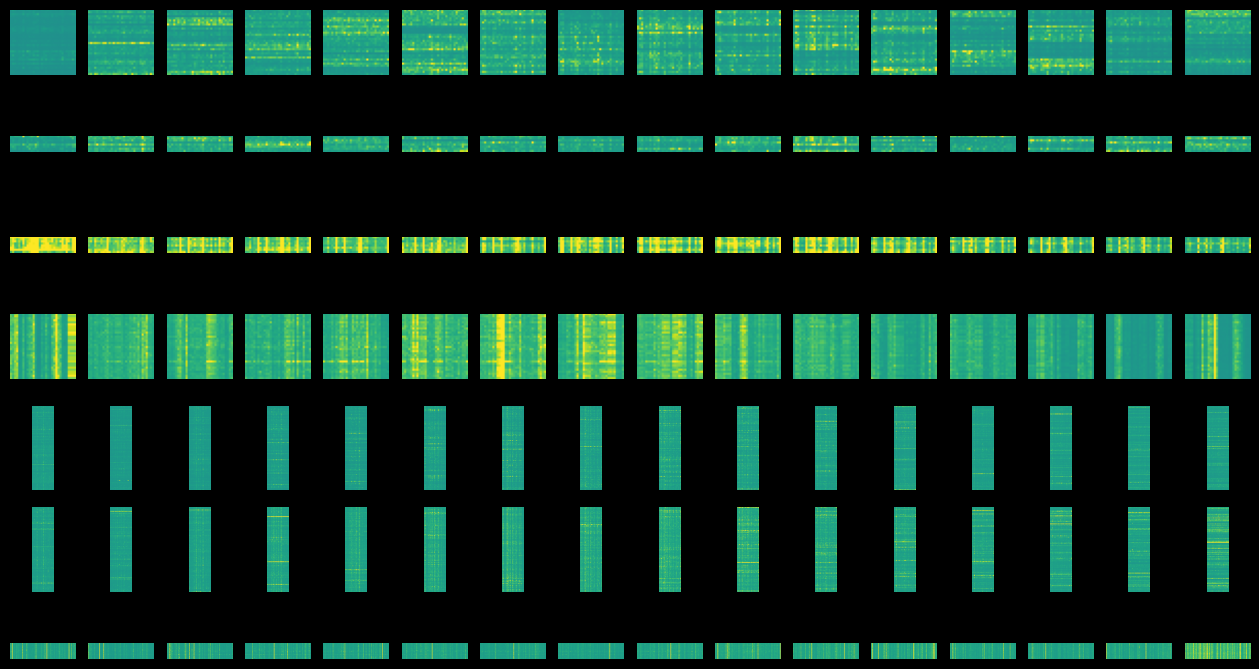

In [11]:
fig=plt.figure(0,(16,9), facecolor='k')
for layer_num in range(16):
    for tensor_index in range(len(tensor_names)):
        tensor_name=tensor_names[tensor_index]
        # w=filtered_params['model.layers.'+str(layer_num)+'.'+tensor_name].detach().cpu()
        g=filtered_params['model.layers.'+str(layer_num)+'.'+tensor_name].grad.detach().cpu()
        
        # w_pooled=max_pool(w.unsqueeze(0))
        g_pooled=max_pool(g.unsqueeze(0))
        # g_pooled=avg_pool(g.unsqueeze(0))

        fig.add_subplot(7, 16, tensor_index*16+layer_num+1)    
        plt.imshow(g_pooled[0], vmin=-0.025, vmax=0.025)
        plt.axis('off')
# plt.savefig(save_dir + '/' + 'grads_max_pooled_global_norm_0001' + '.png', dpi=150, facecolor='k')

- I guess we also dont' have to really even train necessarily right? Like we could just viz gradients for various training examples? I'll want ot train at some point -> but I don't have to to gets some idea of what's going on here I think is the idea. 

In [12]:
lr=1e-6
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  0%|          | 0/10 [00:00<?, ?it/s]

1.8612871170043945


 10%|█         | 1/10 [00:05<00:51,  5.72s/it]

1.5736836194992065


/tmp/ipykernel_2024/4054865937.py:14: UserWarning: Ignoring specified arguments in this call because figure with num: 0 already exists
  fig=plt.figure(0,(16,9), facecolor='k')
 20%|██        | 2/10 [00:11<00:44,  5.57s/it]

1.361653208732605


 30%|███       | 3/10 [00:16<00:37,  5.41s/it]

1.182718276977539


 40%|████      | 4/10 [00:22<00:33,  5.54s/it]

1.025167465209961


 50%|█████     | 5/10 [00:28<00:28,  5.72s/it]

0.8908151388168335


 60%|██████    | 6/10 [00:33<00:22,  5.65s/it]

0.776403546333313


 70%|███████   | 7/10 [00:39<00:16,  5.65s/it]

0.6708822250366211


 80%|████████  | 8/10 [00:44<00:11,  5.58s/it]

0.5720843076705933


 90%|█████████ | 9/10 [00:50<00:05,  5.50s/it]

0.4804304838180542


100%|██████████| 10/10 [00:55<00:00,  5.54s/it]


<Figure size 640x480 with 0 Axes>

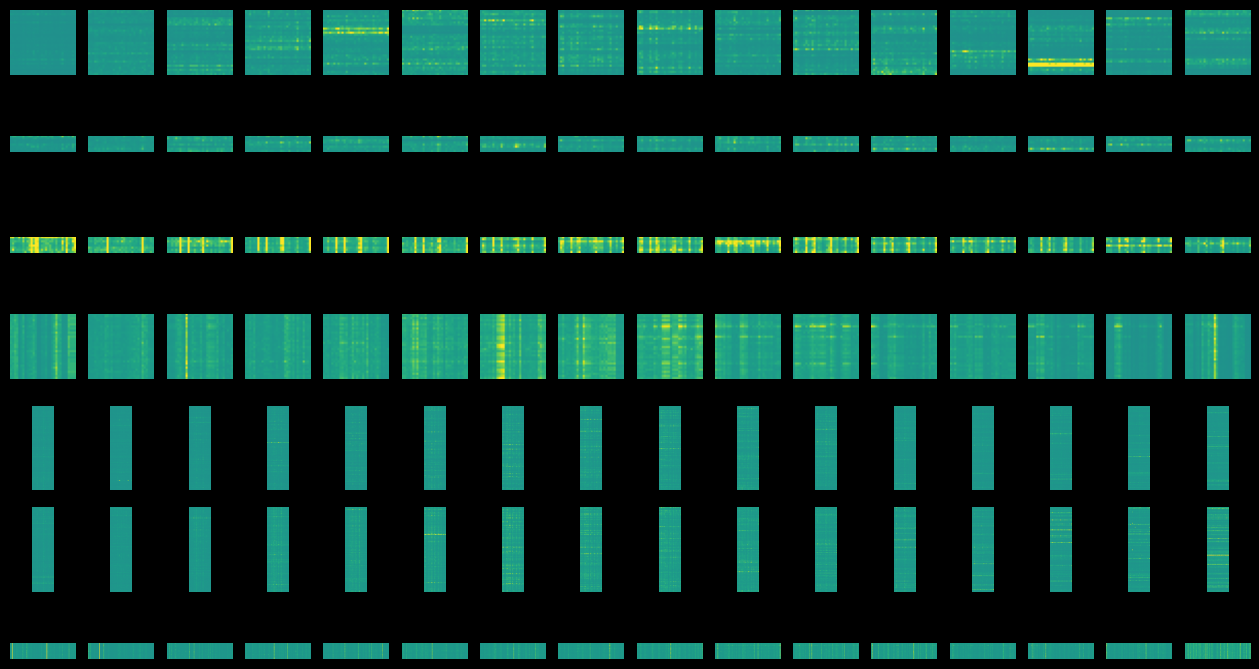

In [13]:
for i in tqdm(range(10)):
    model.train()
    optimizer.zero_grad()
    outputs = model(**inputs, labels=inputs['input_ids'])
    loss = outputs.loss #Ok not just paris loss here -> not sure how much I'm worried about that
    loss.backward()
    print(loss.item())
    optimizer.step()
    
    # Add gradient clipping
    # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    plt.clf()
    fig=plt.figure(0,(16,9), facecolor='k')
    for layer_num in range(16):
        for tensor_index in range(len(tensor_names)):
            tensor_name=tensor_names[tensor_index]
            # w=filtered_params['model.layers.'+str(layer_num)+'.'+tensor_name].detach().cpu()
            g=filtered_params['model.layers.'+str(layer_num)+'.'+tensor_name].grad.detach().cpu()
            
            # w_pooled=max_pool(w.unsqueeze(0))
            g_pooled=max_pool(g.unsqueeze(0))
            # g_pooled=avg_pool(g.unsqueeze(0))
    
            fig.add_subplot(7, 16, tensor_index*16+layer_num+1)    
            plt.imshow(g_pooled[0], vmin=-0.025, vmax=0.025)
            plt.axis('off')
    plt.savefig(save_dir + '/' + 'grads_max_pooled_global_norm_' + str(i).zfill(3) +'.png', dpi=150, facecolor='k')

In [14]:
model.config

LlamaConfig {
  "_attn_implementation_autoset": true,
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128001,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3"
  },
  "rope_theta": 500000.0,
  "tie_word_embeddings": true,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3",
  "use_cache": true,
  "vocab_size": 128256
}

In [16]:
out=model(input_ids.to(device), labels=input_ids.to(device))
out.loss.backward()

In [17]:
filtered_params = {name: p for name, p in model.named_parameters() if p.requires_grad}

In [18]:
lr=1e-6
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [19]:
for i in range(10):
    model.train()
    optimizer.zero_grad()
    outputs = model(**inputs, labels=inputs['input_ids'])
    loss = outputs.loss #Ok not just paris loss here -> not sure how much I'm worried about that
    loss.backward()
    print(loss.item())
    
    # Add gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    optimizer.step()

0.3892461955547333
0.27066946029663086
0.19712142646312714
0.1385638564825058
0.09846523404121399
0.08046362549066544
0.07142399996519089
0.06592347472906113
0.061440613120794296
0.05787507817149162


In [20]:
with torch.no_grad():
    outputs = model(input_ids, labels=input_ids)

my_probs=F.softmax(outputs.logits, dim=-1)

sI=np.argsort(my_probs[0,5, :].detach().cpu().float().numpy())[::-1]
for i in sI[:10]:
    print(i, round(my_probs[0, 5, i].item(),5), tokenizer.decode([i]))

11 0.99719 ,
323 0.00185  and
1174 0.00041 ,
13 0.00016 .
304 4e-05  in
3723 3e-05  United
7427 2e-05  USA
10856 2e-05 ,,
320 2e-05  (
26 1e-05 ;


- Ok yeah so my poor little 3090 just can't do it -> that's a bummer.
- For some reason I do feel like I want to stick with Llama 1b -> os let's stick with llama 1b

In [21]:
save_dir='may_12_3'
os.makedirs(save_dir, exist_ok=True)
kernel_size=64
stride=64

avg_pool = torch.nn.AvgPool2d(kernel_size=kernel_size, stride=stride)
max_pool=torch.nn.MaxPool2d(kernel_size=kernel_size, stride=stride)

tensor_names=['self_attn.q_proj.weight', 'self_attn.k_proj.weight', 'self_attn.v_proj.weight', 'self_attn.o_proj.weight', 
            'mlp.gate_proj.weight', 'mlp.up_proj.weight', 'mlp.down_proj.weight']

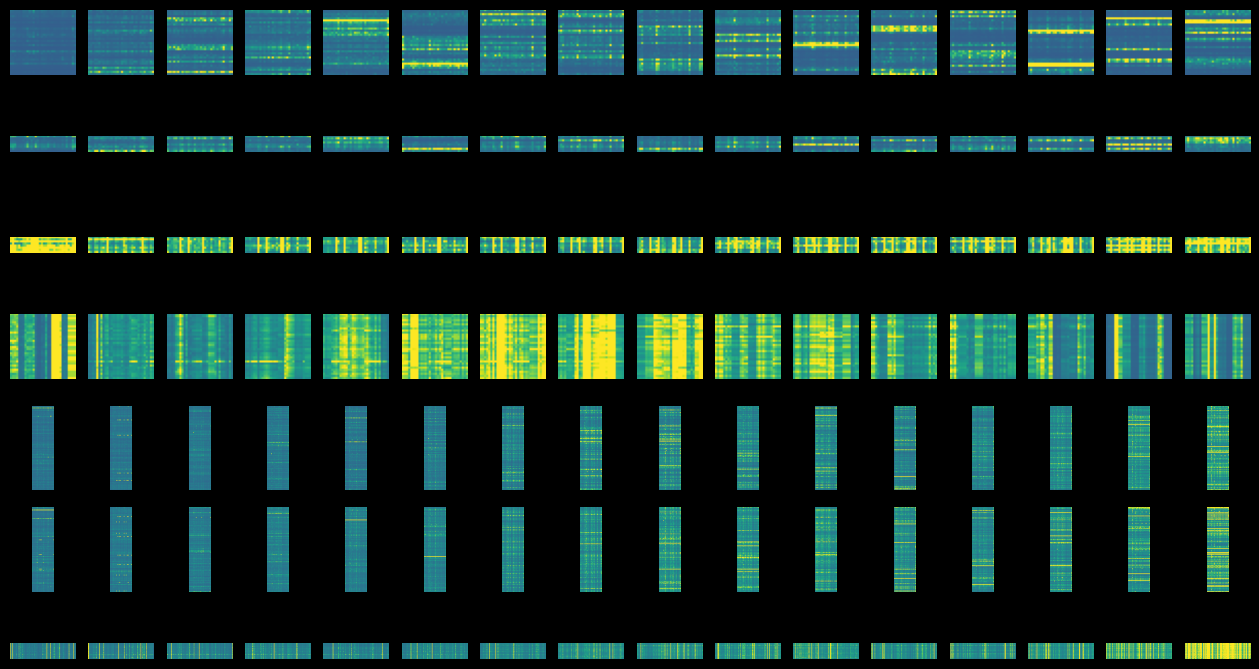

In [22]:
fig=plt.figure(0,(16,9), facecolor='k')
for layer_num in range(16):
    for tensor_index in range(len(tensor_names)):
        tensor_name=tensor_names[tensor_index]
        # w=filtered_params['model.layers.'+str(layer_num)+'.'+tensor_name].detach().cpu()
        g=filtered_params['model.layers.'+str(layer_num)+'.'+tensor_name].grad.detach().cpu()
        
        # w_pooled=max_pool(w.unsqueeze(0))
        g_pooled=max_pool(g.unsqueeze(0))
        # g_pooled=avg_pool(g.unsqueeze(0))

        fig.add_subplot(7, 16, tensor_index*16+layer_num+1)    
        plt.imshow(g_pooled[0], vmin=global_min*0.0001, vmax=global_max*0.0001)
        plt.axis('off')
plt.savefig(save_dir + '/' + 'grads_max_pooled_global_norm_0001' + '.png', dpi=150, facecolor='k')

In [23]:
global_min=0
global_max=0
for k,v in filtered_params.items(): #Hmm i guess I'm doing the global weight average not the global grad average - do we care right now?
    if v.max().item()>global_max:
        global_max=v.max().item()
    if v.min().item()<global_min:
        global_min=v.min().item()

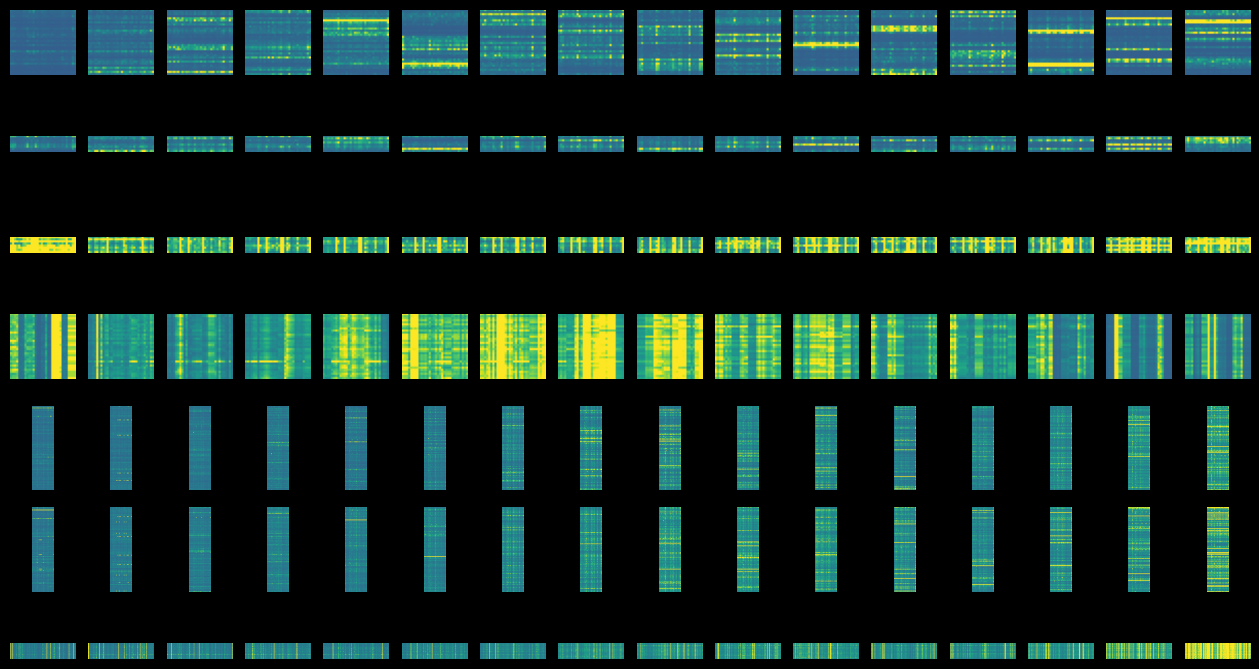

In [24]:
fig=plt.figure(0,(16,9), facecolor='k')
for layer_num in range(16):
    for tensor_index in range(len(tensor_names)):
        tensor_name=tensor_names[tensor_index]
        # w=filtered_params['model.layers.'+str(layer_num)+'.'+tensor_name].detach().cpu()
        g=filtered_params['model.layers.'+str(layer_num)+'.'+tensor_name].grad.detach().cpu()
        
        # w_pooled=max_pool(w.unsqueeze(0))
        g_pooled=max_pool(g.unsqueeze(0))
        # g_pooled=avg_pool(g.unsqueeze(0))

        fig.add_subplot(7, 16, tensor_index*16+layer_num+1)    
        plt.imshow(g_pooled[0], vmin=global_min*0.0001, vmax=global_max*0.0001)
        plt.axis('off')
plt.savefig(save_dir + '/' + 'grads_max_pooled_global_norm_0001' + '.png', dpi=150, facecolor='k')